In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from google.colab import files
uploaded = files.upload()
import io
house_df = pd.read_csv(io.BytesIO(uploaded['kc_house_data.csv']))

Saving kc_house_data.csv to kc_house_data.csv


## 1. Linear Regression. A bit of formalism

Let's have a data consisting of $n$ samples. These samples are $(m+1)$ - dimensional vectors, where first $m$ dimensions are called features (explanatory variables) and will be used to predict the last dimension which is called regressand (dependent variable). 

We will have therefore a $n \times m$ matrix **$X$** (called feature matrix) and vector **$y$** of lenght $n$. 

In our simple example, living squarefeet is a feature, house's price is regressand and the data consists of $100$ samples. It forms $100 \times 1$ feature matrix **$X$** and vector **$y$** of length $100$.

In [2]:
X = house_df.sqft_living.values.reshape(-1,1)[:100]
y = house_df.price.values.reshape(-1,1)[:100]
print(np.shape(X))
print(np.shape(y))

(100, 1)
(100, 1)


Linear regression approach tries to find a vector **$b$** which minimizes the cost function 

$$f_{y}(b) = \dfrac{|Xb - y|^2}{n}, $$

where **$|\cdot|$** is euclidean norm and **$Xb$** is simple matrix multiplication (vector is also a matrix). 

Geometrically (and roughly) speaking, we are determining a line which minimizes the cumulative distance to all the points. 

When such a vector **$b$** is found, we can predict values **$y$** for given features **$X$** by calculating **$Xb$**. We have therefore 

$$y_{pred} = Xb, \\ f_{y}(b) = \dfrac{|y_{pred} - y|^2}{n}. $$

## Exercise 1
a) Create functions *predict(b, X)* and *cost(y_pred, y_true)* implementing theory above.  All inputs should be numpy arrays (take care of dimension scalability!)  
b) For our data **$X,y$**, plot cost as the function of **$b$** (which is one dimensional vector). Plot the line with best slope among  evaluated with *cost* function.

In [3]:
#a)
def predict(b, X):
    return X.dot(b)

def cost(y_pred, y_true):
    return np.true_divide(np.linalg.norm(np.subtract(y_pred, y_true))**2, len(y_true))



#short test:
test_b = np.array([[1],[1],[1]])
test_X = np.array([[1,2,3],[2,5,4],[3,4,5],[4,5,7]])
test_y = np.array([[1],[2],[3],[4]])

print(predict(test_b, test_X))
print(cost(predict(test_b, test_X),test_y))

[[ 6]
 [11]
 [12]
 [16]]
82.75000000000001


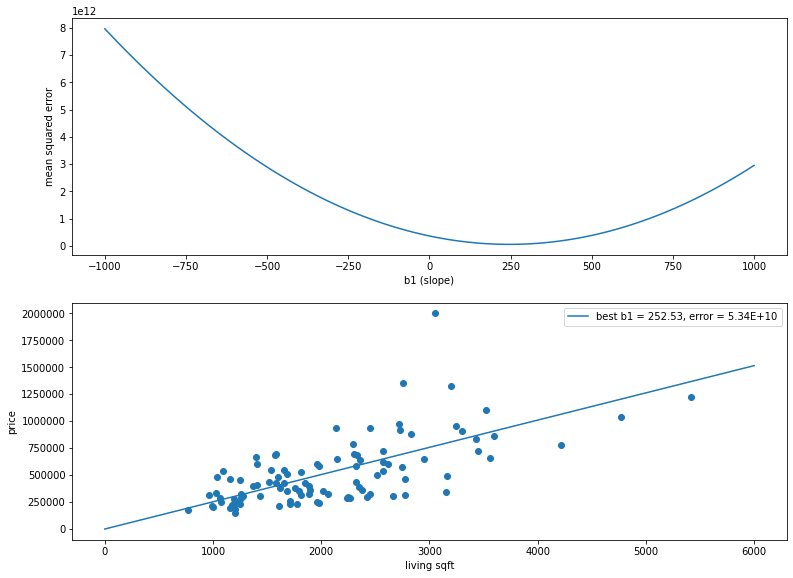

In [4]:
#b)
fig, axs = plt.subplots(2, 1, figsize=[12.8, 9.6])
mse = {}
bs = np.linspace(-1000, 1000, len(X))
for b in bs:
  mse[b] = cost(predict(b, X), y)
axs[0].plot(*zip(*sorted(mse.items())))
axs[0].set_xlabel('b1 (slope)')
axs[0].set_ylabel('mean squared error')
axs[1].scatter(X, y)
X_linspace = np.linspace(0, 6000)
best_b1 = min(mse, key=mse.get)
axs[1].plot(X_linspace, best_b1 * X_linspace, label='best b1 = {:.2f}, error = {:.2E}'.format(best_b1, mse[best_b1]))
axs[1].ticklabel_format(useOffset=False, style='plain')
axs[1].set_xlabel('living sqft')
axs[1].set_ylabel('price')
axs[1].legend()
plt.show()

# We can see that cost function returns the best (the smallest) value (i.e. has local minimum) when slope's value is around 250.
# Plotted line quite accurately predicts house prices.  

# 2. Bias

The line above has limitation of crossing point (0,0). As on our data it doesn't seem harmful, let us check how our model would perform, if all $y$ were shifted by some constant. The interpretation is as follows: the goverment has imposed a new tax in the set amount of 1 million dollar on buying new houses.

As we can see, for the best slope the error has grown almost by the factor of four. In addition we clearly see, that what limits us is indeed the constraint of all lines crossing point $(0,0)$.   

There are two basic solutions of this problem. One of them is centring of the data, that is substracting overall mean from all the values of given feature (or regressand).  

The other is adding bias term, which in this context (different than context discussed during the lectures!) may be understood as constant term in line equation. We simulate adding constant term to result of each prediction by appending artificial feature consisting of ones to **$X$** matrix and additional term to **$b$** vector.

## Exercise 2
a) Add bias column to the **$X$** matrix.  
b) Make the code below compatible with functions that you've created so far.

In [5]:
#a)
X = house_df.sqft_living.values.reshape(-1,1)[:100]
X = np.hstack((X,np.ones((X.shape[0],1))))

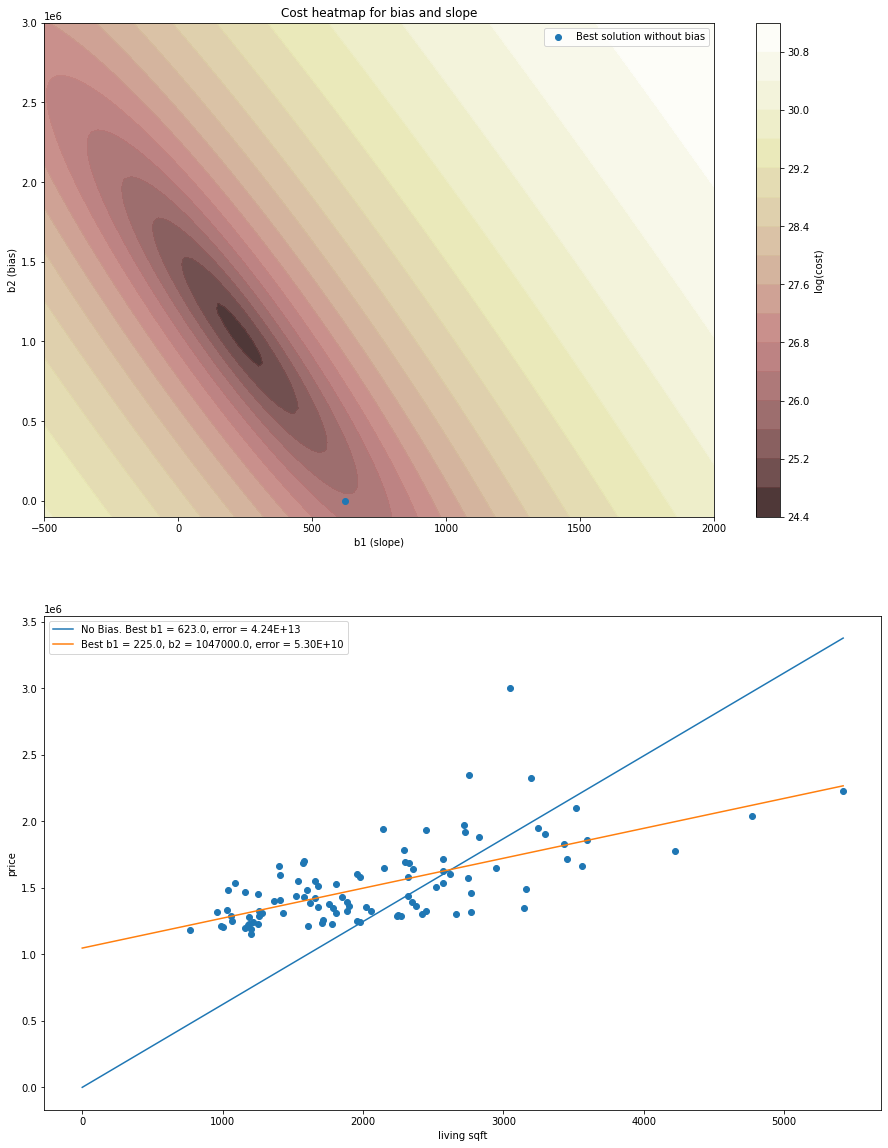

In [6]:
#b)
y_shifted = y+1e6
y_shifted = np.array(y_shifted)
#No Bias Part
b_arr = [np.array(b1) for b1 in np.linspace(-1000, 1000, num=2001)]
cost_arr = [cost(predict(b, X[:,0]), y_shifted) for b in b_arr]
best_b1 = b_arr[np.argmin(cost_arr)]


#Bias Part
nb_of_bs = 101 # compute the cost nb_of_bs times in each dimension
b1 = np.linspace(-500, 2000, num=nb_of_bs) # slope coefficient
b2 = np.linspace(-1e5, 3e6, num=nb_of_bs) # bias
b_x, b_y = np.meshgrid(b1, b2) # generate grid
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X) , y_shifted)


plt.figure(figsize=(15,20)) 
        
plt.subplot(2,1,1)
plt.title("Cost heatmap for bias and slope")

plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
plt.scatter(best_b1, 0, label = "Best solution without bias")
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")
plt.legend()

plt.subplot(2,1,2)

plt.scatter(X.T[0], y_shifted)
plt.xlabel("living sqft")
plt.ylabel("price")

x_model = np.linspace(np.min(X), np.max(X), 1000)
y_model = best_b1*x_model
plt.plot(x_model, y_model, label='No Bias. Best b1 = {}, error = {:.2E}'.format(best_b1, cost_arr[np.argmin(cost_arr)]))

best_b1_2d_ind, best_b2_2d_ind = np.unravel_index(cost_arr_2d.argmin(), cost_arr_2d.shape)
best_b1 = b_x[best_b1_2d_ind,best_b2_2d_ind]
best_b2 = b_y[best_b1_2d_ind,best_b2_2d_ind]

y_model = best_b1*x_model + best_b2
plt.plot(x_model, y_model, label='Best b1 = {}, b2 = {}, error = {:.2E}'.format(best_b1, best_b2, cost_arr_2d[best_b1_2d_ind,best_b2_2d_ind]))

plt.legend()

plt.show()

**Adding bias improved error by three orders of magnitude. Not bad!**

# 3. Standardization

In order to improve performance of many machine learning algorithms, the value standardization is applied. It makes the values of each feature in the data have zero-mean and unit-variance. It is achieved by substracting from each value $x$ the overall mean $\bar{x}$, and then dividing it by feature's standard deviation ${\sigma}$:

$$x' = \frac{x - \bar{x}}{\sigma}. $$

It is important to remember, that bias column should not be standardize!

## Exercise 3
a) Implement function standardize(), which standardize the feature matrix and returns it together with two vectors containing original features' means and standard deviations.  
b) Implement function destandardize(), which restores the original data given standardized feature matrix X and vectors containing original features' means and standard deviations.  
c) Plot original $X,y$ data. Then plot it after standardization. Then plot it after destandardisation.

In [7]:
#a)
def standardize(X):
  mean = np.mean(X, axis=0)
  std = np.std(X, axis=0)
  return np.array([np.array(np.divide(np.subtract(x, mean), std)) for x in X]), mean, std

#b)
def destandardize(X, mean, std):
  return np.array([np.add(np.multiply(x, std), mean) for x in X])

#short test:
W = [[1,2,3],[2,5,4],[3,4,5],[4,5,7]]
std_W, og_means_W, og_stds_W = standardize(W)
print('Standardized W:\n', std_W)
destd_W = destandardize(std_W, og_means_W, og_stds_W)
print('Destandardized W:\n', destd_W)
#Hint: with np.mean and np.std first function is three lines long. The second is one-liner.

Standardized W:
 [[-1.34164079 -1.63299316 -1.18321596]
 [-0.4472136   0.81649658 -0.50709255]
 [ 0.4472136   0.          0.16903085]
 [ 1.34164079  0.81649658  1.52127766]]
Destandardized W:
 [[1. 2. 3.]
 [2. 5. 4.]
 [3. 4. 5.]
 [4. 5. 7.]]


[]

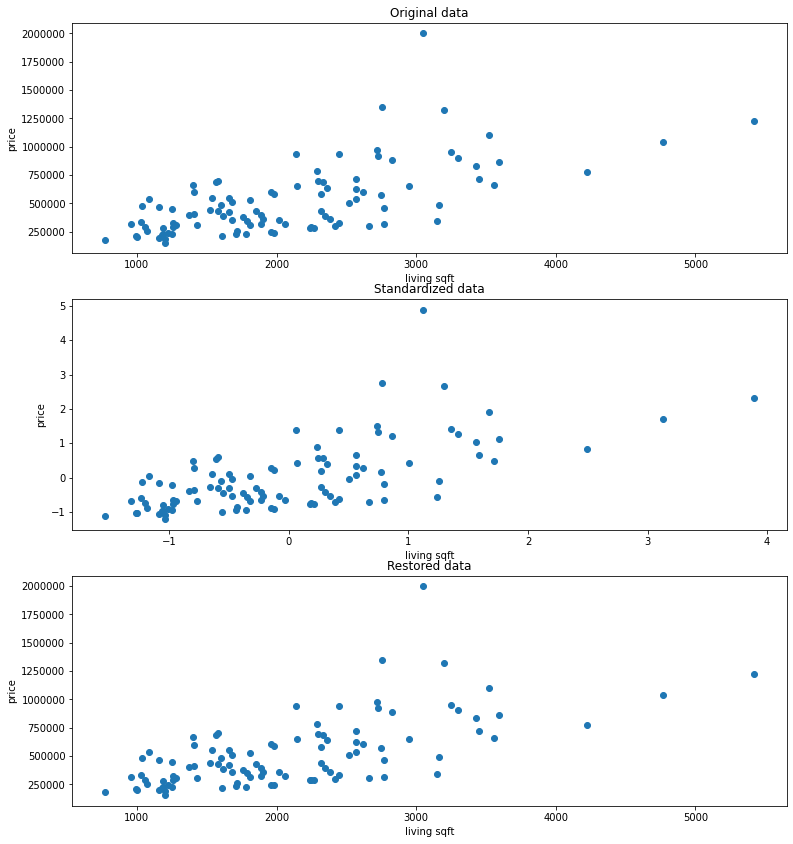

In [8]:
#c)
fig, axs = plt.subplots(3, 1, figsize=[12.8, 14.4])
X = house_df.sqft_living.values.reshape(-1,1)[:100]
axs[0].set_title('Original data')
axs[0].scatter(X, y)
axs[1].set_title('Standardized data')
std_X, og_means_X, og_stds_X = standardize(X)
std_y, og_means_y, og_stds_y = standardize(y)
axs[1].scatter(std_X.reshape(-1,1), std_y)
axs[2].set_title('Restored data')
axs[2].scatter(destandardize(std_X, og_means_X, og_stds_X), destandardize(std_y, og_means_y, og_stds_y))
for ax in axs:
  ax.set_xlabel('living sqft')
  ax.set_ylabel('price')
  ax.ticklabel_format(useOffset=False, style='plain')
plt.plot()

# We can see that standardizing the data decreased data's values to the point
# that their ratio is easier for us to interpret and it's faster to operate on
# values a couple of magnitudes smaller.

## 3. Gradient Descent Method

In previous examples we were determining the approximate value of optimal vector **$b$** by finding best arguments from pre-defined grid. This solution is neither fast nor precise. Although in theory it is possible to find vector **$b$** analytically, it requires inversing large matrices, as the close form for **$b$** is $b=(X^\mathsf{T}X)^{-1}X^\mathsf{T}y$.

The other approach is to find approximation of **$b$** is Gradient Descent Method. Let us recall that for function $f: \ R^n \to R$ a gradient 

$$\nabla f =  \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \vdots \\ \frac{\partial f}{\partial x_n} \end{bmatrix}$$

is the direction of the biggest increase of $f$. Using linearity of derivative, $-\nabla f$ is the direction of the biggest decrease. Gradient Descent Method is based on iterative moving in the direction opposite to gradient, and by these means approaching the minimum.

#### GDM step by step:  
1. Choose starting point $x_{0}$ and parameters: *learning rate* and *precision*,
2. Update $x_{i+1} = x_{i} - \nabla f(x_{i})\cdot lr$, where $lr$ is learning rate parameter,
3. If $(|\nabla f(x_{i})| < precision)$, end. If not, go back to point 2.

One of many limitations of GMD may be knowledge of function's gradient. Luckily for us, it is quite easy in case of linear regression with mean square error cost function. We have

$$ \nabla f_{y}(b) = \nabla\dfrac{|Xb−y|^2}{n} = \dfrac{2X^\mathsf{T}(Xb−y)}{n}.  $$

## Exercise 4
a) Create functions: *gradient()* which computes gradient for linear regresion and *gradient_descent_step()* which returns new vector **b** being the result of one GDM step.  

b) Take **$X$** consisting of *sqft_living* together with bias column. Set **$y$** as price. Standardize both **$X$** (without bias) and **$y$**. Plot a heatmap showing dependence of cost function's value on vector **$b$**. Mark first 5 steps of gradient descent with *learning rate* = $0.2$, starting from **$b =  \begin{bmatrix} 3 \\ 2 \end{bmatrix}$**. Experiment with other *learning rates*.  

c) Take **$X$** consisting of *sqft_living* and *sqft_lot*. Set **$y$** as price. Standardize both **$X$** and **$y$**. Plot a heatmap showing dependence of cost function's value on vector **$b$**. Mark first 5 steps of gradient descent with *learning rate* = $0.2$, starting from **$b =  \begin{bmatrix} 3 \\ 1 \end{bmatrix}$**. Experiment with other *learning rates*.  

d) Try to redo above points without standarization. How can you explain such results?


In [9]:
#a)

def gradient(b, X, y):
    return np.array(np.divide(np.dot(np.multiply(X.T, 2), np.subtract(np.dot(X, b), y)), len(X)))

def gradient_descent_step(b, X, y, lr):
    return np.array(np.subtract(b, gradient(b, X, y) * 0.1))


#short test:
test_b = np.array([[1],[1],[1]])
test_X = np.array([[1,2,3],[2,5,4],[3,4,5],[4,5,7]])
test_y = np.array([[1],[2],[3],[4]])

print(gradient(test_b, test_X, test_y))
print(gradient_descent_step(test_b, test_X, test_y, 0.1))

[[49. ]
 [75.5]
 [90. ]]
[[-3.9 ]
 [-6.55]
 [-8.  ]]


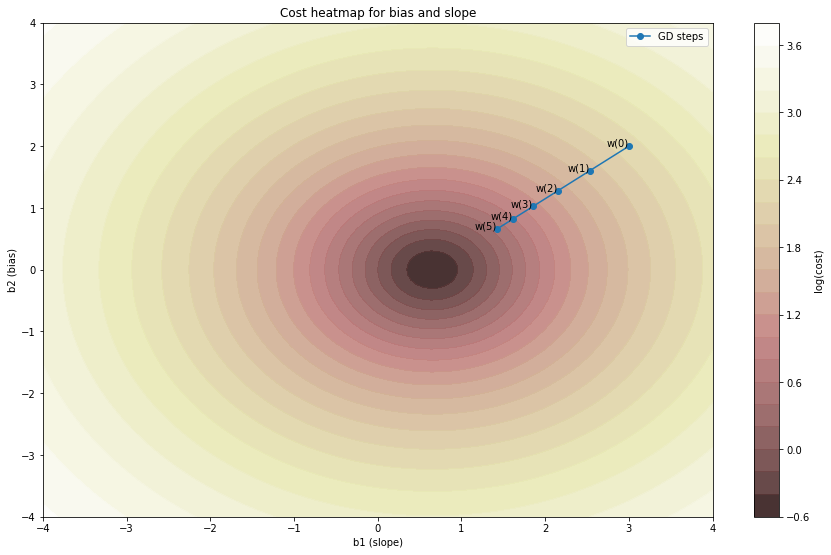

Bias in 5th step: 0.6553599999999996


In [23]:
#b)
# Take  X  consisting of sqft_living together with bias column. Set  y  as price.
# Standardize both  X  (without bias) and  y . Plot a heatmap showing dependence of cost function's value on vector  b .
# Mark first 5 steps of gradient descent with learning rate =  0.2 , starting from  b=[3 2] . Experiment with other learning rates.
X = house_df.sqft_living.values.reshape(-1,1)[:100]
standardized_X, _, _ = standardize(X)
standardized_X_with_bias = np.hstack((standardized_X, np.ones((standardized_X.shape[0],1))))
standardized_y, _, _ = standardize(y)

nb_of_bs = 101 # compute the cost nb_of_bs times in each dimension
b1 = np.linspace(-4, 4, num=nb_of_bs) # slope coefficient
b2 = np.linspace(-4, 4, num=nb_of_bs) # bias
b_x, b_y = np.meshgrid(b1, b2) # generate grid
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix
for i in range(nb_of_bs):
  for j in range(nb_of_bs):
    cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), standardized_X_with_bias), standardized_y)

plt.figure(figsize=(15,20))
plt.subplot(2,1,1)
plt.title('Cost heatmap for bias and slope')
plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")

learning_rate = 0.2
b = np.array([[3], [2]])
bs = {}
bs[b.item(0)] = b.item(1)
for _ in range(5):  
    b = gradient_descent_step(b, standardized_X_with_bias, standardized_y, learning_rate)
    bs[b.item(0)] = b.item(1)

plt.plot(*zip(*sorted(bs.items())), '-o', label='GD steps')

plt.legend()

[plt.annotate('w({})'.format(i), (key_value[0], key_value[1]), horizontalalignment='right') for key_value, i in zip(bs.items(), range(len(bs.items())))]

plt.show()

print('Bias in 5th step:', min(bs.values()))

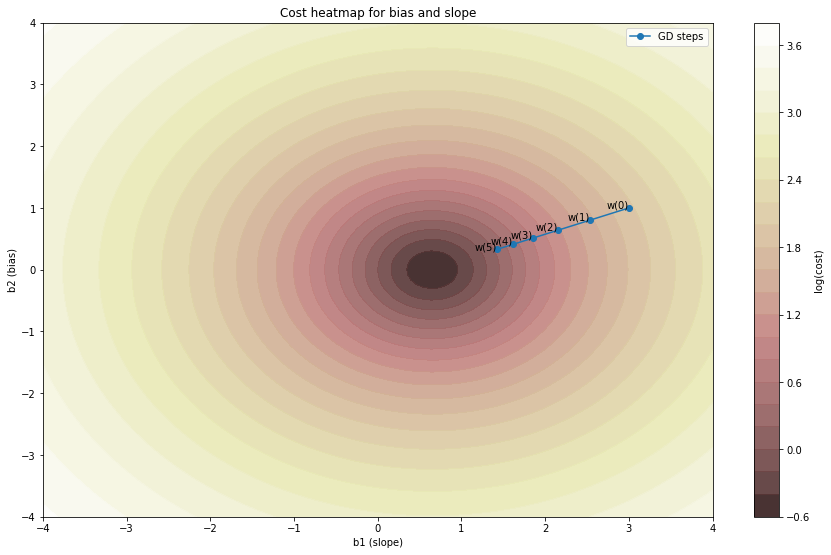

Bias in 5th step: 0.3276799999999997


In [24]:
#c)
# Take  X  consisting of sqft_living together with bias column. Set  y  as price.
# Standardize both  X  (without bias) and  y . Plot a heatmap showing dependence of cost function's value on vector  b .
# Mark first 5 steps of gradient descent with learning rate =  0.2 , starting from  b=[3 1] . Experiment with other learning rates.
X = house_df.sqft_living.values.reshape(-1,1)[:100]
standardized_X, _, _ = standardize(X)
standardized_X_with_bias = np.hstack((standardized_X, np.ones((standardized_X.shape[0],1))))
standardized_y, _, _ = standardize(y)

nb_of_bs = 101 # compute the cost nb_of_bs times in each dimension
b1 = np.linspace(-4, 4, num=nb_of_bs) # slope coefficient
b2 = np.linspace(-4, 4, num=nb_of_bs) # bias
b_x, b_y = np.meshgrid(b1, b2) # generate grid
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix
for i in range(nb_of_bs):
  for j in range(nb_of_bs):
    cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), standardized_X_with_bias), standardized_y)

plt.figure(figsize=(15,20))
plt.subplot(2,1,1)
plt.title('Cost heatmap for bias and slope')
plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")

learning_rate = 0.2
b = np.array([[3], [1]])
bs = {}
bs[b.item(0)] = b.item(1)
for _ in range(5):  
    b = gradient_descent_step(b, standardized_X_with_bias, standardized_y, learning_rate)
    bs[b.item(0)] = b.item(1)

plt.plot(*zip(*sorted(bs.items())), '-o', label='GD steps')

plt.legend()

[plt.annotate('w({})'.format(i), (key_value[0], key_value[1]), horizontalalignment='right') for key_value, i in zip(bs.items(), range(len(bs.items())))]

plt.show()

print('Bias in 5th step:', min(bs.values()))
# As we can see, changing starting b vector helped to achieve better bias in the end.

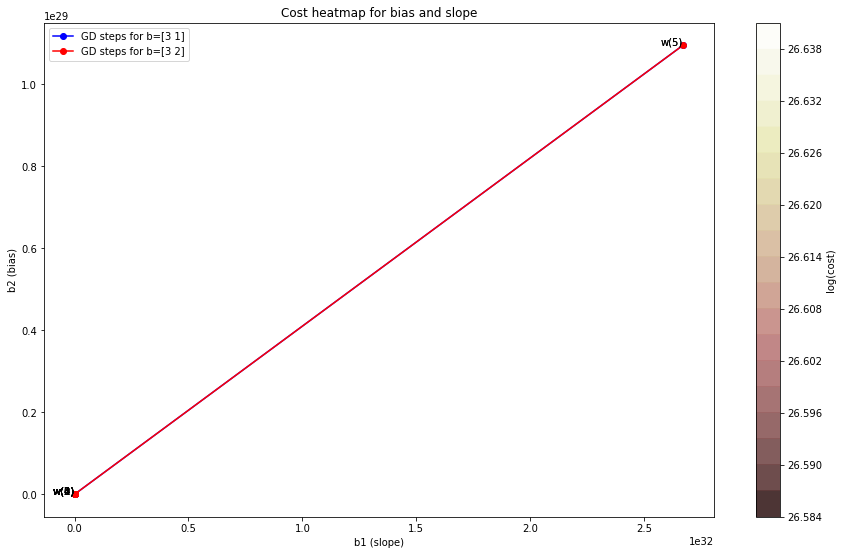

Bias and slope for b=[3 1]: {3: 1, 247568553.536: 102577.43800000001, -252314541916915.78: -103420091936.52238, 2.5715176775886855e+20: 1.0540280326257035e+17, -2.6208173004638677e+26: -1.074235237484182e+23, 2.6710620666825375e+32: 1.094829842976788e+29}
Bias and slope for b=[3 2]: {3: 2, 247568135.79200003: 102578.23800000001, -252314116164579.53: -103419917425.83287, 2.5715133384425924e+20: 1.0540262540722602e+17, -2.6208128781302206e+26: -1.0742334248333592e+23, 2.6710575595665147e+32: 1.0948279955748911e+29}


In [34]:
# d) Try to redo above points without standarization. How can you explain such results?
X = house_df.sqft_living.values.reshape(-1,1)[:100]
X_with_bias = np.hstack((X, np.ones((X.shape[0],1))))

nb_of_bs = 101 # compute the cost nb_of_bs times in each dimension
b1 = np.linspace(-4, 4, num=nb_of_bs) # slope coefficient
b2 = np.linspace(-4, 4, num=nb_of_bs) # bias
b_x, b_y = np.meshgrid(b1, b2) # generate grid
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix
for i in range(nb_of_bs):
  for j in range(nb_of_bs):
    cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X_with_bias), y)

plt.figure(figsize=(15,20))
plt.subplot(2,1,1)
plt.title('Cost heatmap for bias and slope')
plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")

learning_rate = 0.2
b1 = np.array([[3], [1]])
b2 = np.array([[3], [2]])
b1s = {}
b2s = {}
b1s[b1.item(0)] = b1.item(1)
b2s[b2.item(0)] = b2.item(1)
for _ in range(5):  
    b1 = gradient_descent_step(b1, X_with_bias, y, learning_rate)
    b2 = gradient_descent_step(b2, X_with_bias, y, learning_rate)
    b1s[b1.item(0)] = b1.item(1)
    b2s[b2.item(0)] = b2.item(1)

plt.plot(*zip(*sorted(b1s.items())), '-o', color='blue', label='GD steps for b=[3 1]')
plt.plot(*zip(*sorted(b2s.items())), '-o', color='red', label='GD steps for b=[3 2]')

plt.legend()

[plt.annotate('w({})'.format(i), (key_value[0], key_value[1]), horizontalalignment='right') for key_value, i in zip(b1s.items(), range(len(b1s.items())))]
[plt.annotate('w({})'.format(i), (key_value[0], key_value[1]), horizontalalignment='right') for key_value, i in zip(b2s.items(), range(len(b2s.items())))]

plt.show()
print('Bias and slope for b=[3 1]:', b1s)
print('Bias and slope for b=[3 2]:', b2s)
# The distance we move each step is dictated by the magnitude of the gradient, so in our case where the data is not standardized, the steps are much bigger,
# which is why the plot with such axis limits etc. can be misleading (printing biases and slopes for each step shows that bias and slope can change each step
#even by six orders of magnitude)